# Non-stationary Heteroscedastic Models

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import jax
import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import arviz as az
import regdata as rd

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import jaxopt

import gpax.kernels as gpk
import gpax.likelihoods as gpl
import gpax.means as gpm
from gpax.models import ExactGPRegression, LatentGPHeinonen, LatentGPDeltaInducing, LatentGPPlagemann, LatentGP
from gpax.utils import index_pytree, DataScaler
from gpax.core import set_positive_bijector

jax.config.update("jax_enable_x64", True)

# set_positive_bijector(tfb.Exp())

/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: LOCAL is an invalid version and will not be supported in a future release
  warnings.warn(
/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: pre-0.1 is an invalid version and will not be supported in a future release
  warnings.warn(


## Load and preprocess dataset

2023-02-06 20:06:20.358766: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(dtype('float64'), dtype('float64'), dtype('float64'))

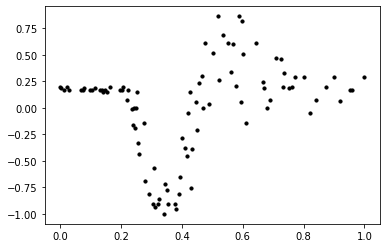

In [2]:
X, y, _ = rd.MotorcycleHelmet().get_data()
scaler = DataScaler(X, y)
X, y = scaler.transform(X, y)

X_test = jnp.linspace(-1, 2, 250)[:, None]

plt.scatter(X, y, s=10, c="k");
X.dtype, y.dtype, X_test.dtype

## Heteroscedastic likelihood model

### [Heinonen et al.](https://proceedings.mlr.press/v51/heinonen16.html) method

Heinonen, M., Mannerström, H., Rousu, J., Kaski, S., & Lähdesmäki, H. (2016). Non-Stationary Gaussian Process Regression with Hamiltonian Monte Carlo. In Proceedings of the 19th International Conference on Artificial Intelligence and Statistics (pp. 732–740). PMLR.


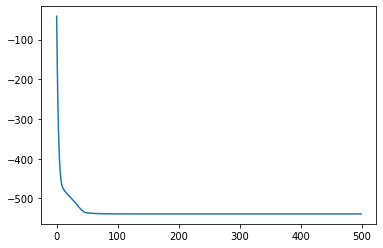

In [3]:
kernel = gpk.Scale(X, gpk.RBF(X, lengthscale=0.05), variance=0.3**2)
latent_model_kernel = gpk.Scale(X, gpk.RBF(X, lengthscale=0.3), variance=1.0).trainable(False)  # Fixed latent model kernel

# There are no inducing points in this model but X_inducing name is used for consistency
latent_model = LatentGPHeinonen(X_inducing=X, kernel=latent_model_kernel)
likelihood = gpl.Heteroscedastic(latent_model=latent_model)

model = ExactGPRegression(kernel, likelihood, gpm.Average(), X_inducing=X)

# This function is triggered after the default initialization
def customize_fn(model):
    model.kernel.variance.set_value(jnp.array(0.3)**2)
    model.kernel.base_kernel.lengthscale.set_value(jnp.array([0.05]))
    model.likelihood.latent_model.reverse_init(jnp.array(0.05))

key = jr.PRNGKey(100)
result = model.fit(key, X, y, customize_fn, lr=0.1, epochs=500)

plt.plot(result["loss_history"]);

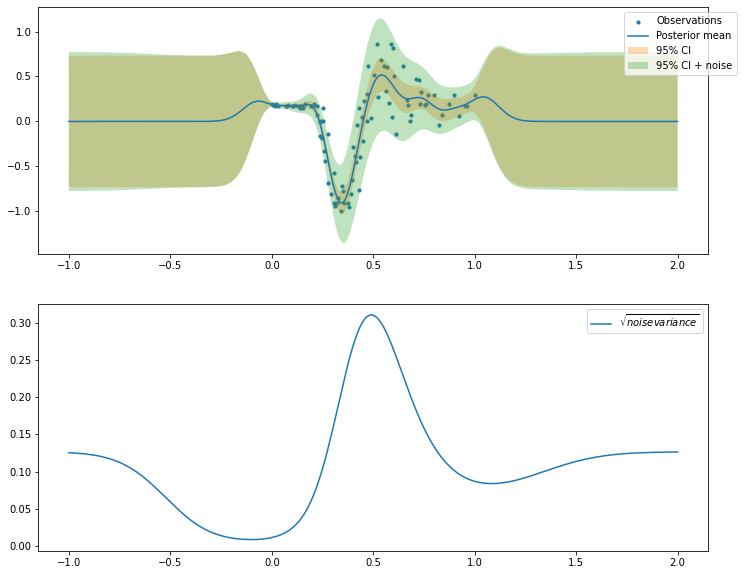

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10));
model.plot(X, y, X_test, ax=ax[0], s=10);

ax[1].plot(X_test, model.likelihood.get_likelihood_fn(X)(X_test), label=r"$\sqrt{noise variance}$");
ax[1].legend();

#### Second order optimization

In [5]:
def loss_fn(raw_params, x, y):
    model.set_raw_parameters(raw_params)
    return -model.log_probability(x, y)

key = jr.PRNGKey(10)
model.initialize(key).get_raw_parameters()
model.kernel.variance.set_value(jnp.array(0.3)**2)
model.kernel.base_kernel.lengthscale.set_value(jnp.array([0.05]))
model.likelihood.latent_model.reverse_init(jnp.array(0.05))
raw_params = model.get_raw_parameters()

solver = jaxopt.ScipyMinimize(fun=loss_fn)
solution = solver.run(raw_params, x=X, y=y)

model.set_raw_parameters(solution.params)

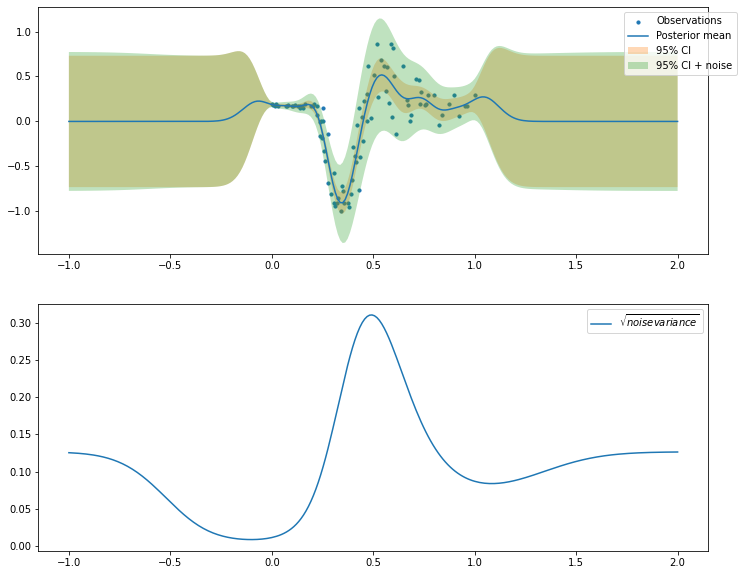

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10));
model.plot(X, y, X_test, ax=ax[0], s=10);

ax[1].plot(X_test, model.likelihood.get_likelihood_fn(X)(X_test), label=r"$\sqrt{noise variance}$");
ax[1].legend();

### [Plagemann et al.](https://link.springer.com/chapter/10.1007/978-3-540-87481-2_14) method

Plagemann, C., Kersting, K., Burgard, W. (2008). Nonstationary Gaussian Process Regression Using Point Estimates of Local Smoothness. In: Daelemans, W., Goethals, B., Morik, K. (eds) Machine Learning and Knowledge Discovery in Databases. ECML PKDD 2008. Lecture Notes in Computer Science(), vol 5212. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-540-87481-2_14

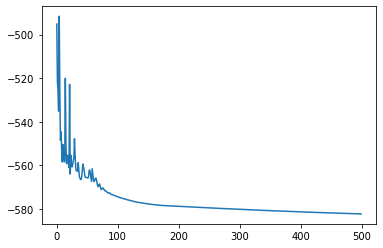

In [7]:
kernel = gpk.Scale(X, gpk.RBF(X, lengthscale=0.05), variance=0.3**2)
latent_model_kernel = gpk.Scale(X, gpk.RBF(X, lengthscale=0.3), variance=1.0).trainable(False)  # Fixed latent model kernel

X_inducing = X[::10]
latent_model = LatentGPPlagemann(X_inducing=X_inducing, kernel=latent_model_kernel)
likelihood = gpl.Heteroscedastic(latent_model=latent_model)

model = ExactGPRegression(kernel, likelihood, gpm.Average(), X_inducing=X_inducing)

# This function is triggered after the default initialization
def customize_fn(model):
    model.kernel.variance.set_value(jnp.array(0.3)**2)
    model.kernel.base_kernel.lengthscale.set_value(jnp.array([0.05]))
    model.likelihood.latent_model.reverse_init(jnp.array(0.05))

key = jr.PRNGKey(100)
result = model.fit(key, X, y, customize_fn, lr=0.1, epochs=500)

plt.plot(result["loss_history"]);

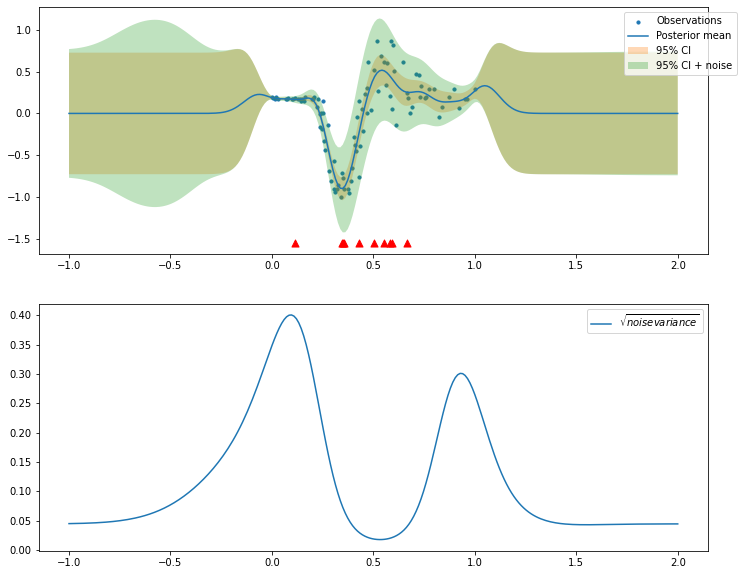

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10));
model.plot(X, y, X_test, ax=ax[0], s=10);
ax[0].scatter(X_inducing, jnp.array(ax[0].get_ylim()[0]).repeat(len(X_inducing)), s=50, c="r", marker="^");

ax[1].plot(X_test, model.likelihood.get_likelihood_fn(X_inducing)(X_test), label=r"$\sqrt{noise variance}$");
ax[1].legend();

#### Second order optimization

In [9]:
def loss_fn(raw_params, x, y):
    model.set_raw_parameters(raw_params)
    return -model.log_probability(x, y)

key = jr.PRNGKey(10)
model.initialize(key)
model.kernel.variance.set_value(jnp.array(0.3)**2)
model.kernel.base_kernel.lengthscale.set_value(jnp.array([0.05]))
model.likelihood.latent_model.reverse_init(jnp.array(0.05))
raw_params = model.get_raw_parameters()

solver = jaxopt.ScipyMinimize(fun=loss_fn)
solution = solver.run(raw_params, x=X, y=y)

model.set_raw_parameters(solution.params)

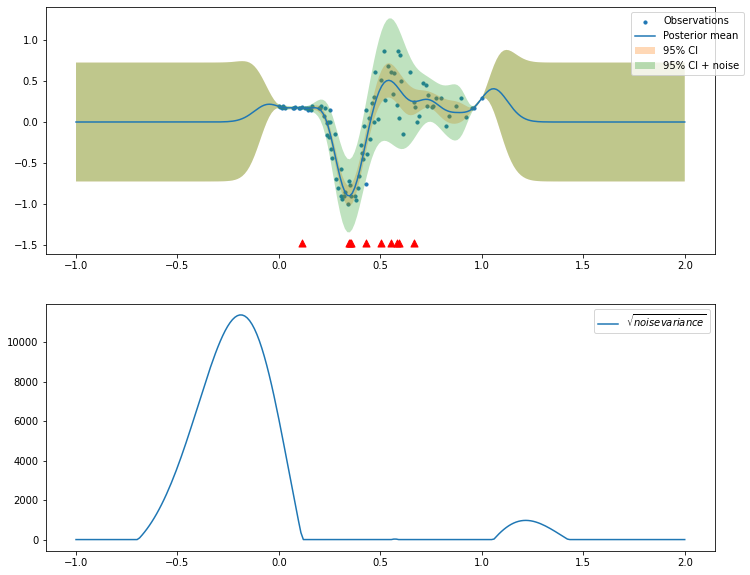

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10));
model.plot(X, y, X_test, ax=ax[0], s=10);
ax[0].scatter(X_inducing, jnp.array(ax[0].get_ylim()[0]).repeat(len(X_inducing)), s=50, c="r", marker="^");

ax[1].plot(X_test, model.likelihood.get_likelihood_fn(X_inducing)(X_test), label=r"$\sqrt{noise variance}$");
ax[1].legend();

### [Patel et al.](https://arxiv.org/abs/2210.10964) method

Patel, Z, Batra, N, Murphy, K. "Uncertainty Disentanglement with Non-stationary Heteroscedastic Gaussian Processes for Active Learning". arXiv preprint arXiv:2210.10964 2022.

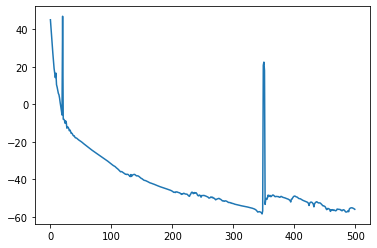

In [11]:
kernel = gpk.Scale(X, gpk.RBF(X, lengthscale=0.05), variance=0.3**2)
latent_model_kernel = gpk.Scale(X, gpk.RBF(X, lengthscale=0.3), variance=1.0).trainable(False)  # Fixed latent model kernel

X_inducing = X[::10]
latent_model = LatentGPDeltaInducing(X_inducing=X_inducing, kernel=latent_model_kernel)
likelihood = gpl.Heteroscedastic(latent_model=latent_model)

model = ExactGPRegression(kernel, likelihood, gpm.Average(), X_inducing=X_inducing)

# This function is triggered after the default initialization
def customize_fn(model):
    model.kernel.variance.set_value(jnp.array(0.3)**2)
    model.kernel.base_kernel.lengthscale.set_value(jnp.array([0.05]))
    model.likelihood.latent_model.reverse_init(jnp.array(0.05))

key = jr.PRNGKey(100)
result = model.fit(key, X, y, customize_fn, lr=0.01, epochs=500)

plt.plot(result["loss_history"]);

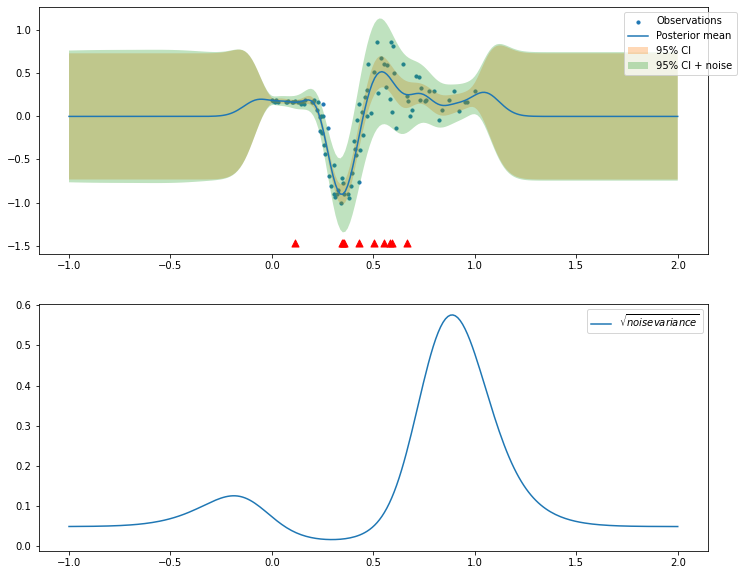

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10));
model.plot(X, y, X_test, ax=ax[0], s=10);
ax[0].scatter(X_inducing, jnp.array(ax[0].get_ylim()[0]).repeat(len(X_inducing)), s=50, c="r", marker="^");

ax[1].plot(X_test, model.likelihood.get_likelihood_fn(X_inducing)(X_test), label=r"$\sqrt{noise variance}$");
ax[1].legend();

#### Second order optimization

In [13]:
def loss_fn(raw_params, x, y):
    model.set_raw_parameters(raw_params)
    return -model.log_probability(x, y)

key = jr.PRNGKey(10)
model.initialize(key)
model.kernel.variance.set_value(jnp.array(0.3)**2)
model.kernel.base_kernel.lengthscale.set_value(jnp.array([0.05]))
model.likelihood.latent_model.reverse_init(jnp.array(0.05))
raw_params = model.get_raw_parameters()

solver = jaxopt.ScipyMinimize(fun=loss_fn)
solution = solver.run(raw_params, x=X, y=y)

model.set_raw_parameters(solution.params)

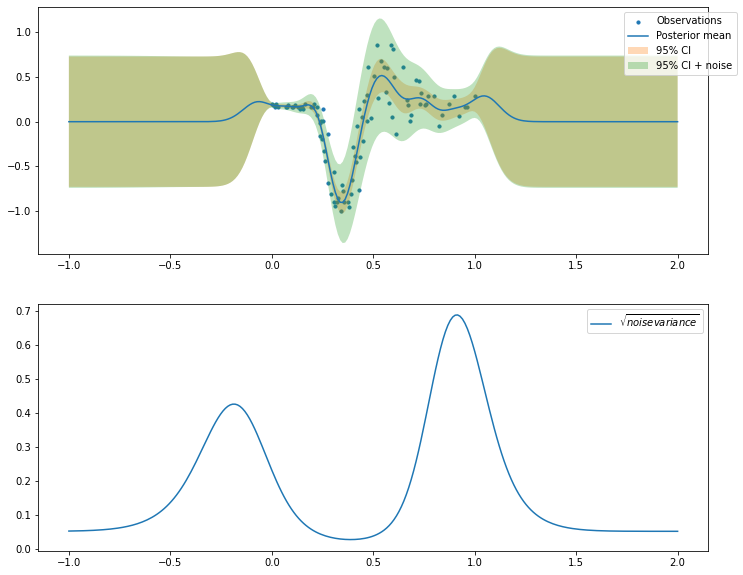

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10));
model.plot(X, y, X_test, ax=ax[0], s=10);

ax[1].plot(X_test, model.likelihood.get_likelihood_fn(X_inducing)(X_test), label=r"$\sqrt{noise variance}$");
ax[1].legend();